In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_parquet('/home/ev357/miniconda3/envs/tcbench/lib/python3.10/site-packages/tcbench/libtcdatasets/datasets/mirage19/preprocessed/imc23/mirage19_filtered_minpkts10.parquet')
print(df.columns)
print(df.shape)
df = df.drop(columns=['conn_id', 'android_name'])
df = df.rename(columns={'flow_metadata_bf_label': 'label', 
                        'flow_metadata_bf_labeling_type': 'labeling_type',
                        'packet_data_l4_raw_payload': 'raw_payload', 
                        'flow_metadata_bf_l4_payload_bytes': 'payload_bytes',
                        'flow_metadata_bf_duration': 'duration',
                        'timetofirst': 'time_to_first',})
print(df.columns)
print(df.shape)

Index(['row_id', 'conn_id', 'packet_data_l4_raw_payload',
       'flow_metadata_bf_label', 'flow_metadata_bf_labeling_type',
       'flow_metadata_bf_l4_payload_bytes', 'flow_metadata_bf_duration',
       'strings', 'android_name', 'device_name', 'app', 'src_ip', 'src_port',
       'dst_ip', 'dst_port', 'proto', 'packets', 'pkts_size', 'pkts_dir',
       'timetofirst'],
      dtype='object')
(64172, 20)
Index(['row_id', 'raw_payload', 'label', 'labeling_type', 'payload_bytes',
       'duration', 'strings', 'device_name', 'app', 'src_ip', 'src_port',
       'dst_ip', 'dst_port', 'proto', 'packets', 'pkts_size', 'pkts_dir',
       'time_to_first'],
      dtype='object')
(64172, 18)


In [3]:
df.iloc[0]

row_id                                                           0
raw_payload      [[], [], [], [22, 3, 1, 2, 0, 1, 0, 1, 252, 3,...
label                                              de.motain.iliga
labeling_type                                          most-common
payload_bytes                                               4319.0
duration                                                326.368095
strings                  [play.googleapis.com, http/1.1, http/1.1]
device_name                                  Mi5_38_a4_ed_18_cc_bf
app                                                de.motain.iliga
src_ip                                              192.168.20.105
src_port                                                     39031
dst_ip                                               216.58.198.10
dst_port                                                       443
proto                                                            6
packets                                                       

In [4]:
def process_flow(row):
    feature_vector = []

    feature_vector.append(row['payload_bytes'])
    feature_vector.append(row['duration'])

    formatted_src_ip = "".join(f"{int(octet):03d}" for octet in (row['src_ip']).split("."))
    feature_vector.append(int(formatted_src_ip))
    feature_vector.append(row['src_port'])

    formatted_dst_ip = "".join(f"{int(octet):03d}" for octet in (row['src_ip']).split("."))
    feature_vector.append(int(formatted_dst_ip))
    feature_vector.append(row['dst_port'])

    feature_vector.append(row['proto'])
    feature_vector.append(row['packets'])

    pkts_size = np.array(row['pkts_size']) if len(row['pkts_size']) > 0 else np.array([0])
    feature_vector.extend([np.mean(pkts_size), np.std(pkts_size), np.min(pkts_size), np.max(pkts_size)])

    pkts_dir = np.array(row['pkts_dir']) if len(row['pkts_dir']) > 0 else np.array([0])
    feature_vector.append(np.sum(pkts_dir) / len(pkts_dir) if len(pkts_dir) > 0 else 0)

    time_to_first = np.array(row['time_to_first']) if len(row['time_to_first']) > 0 else np.array([0])
    feature_vector.extend([np.mean(time_to_first), np.std(time_to_first), np.min(time_to_first), np.max(time_to_first)])

    return feature_vector

feature_matrix = np.array(df.apply(process_flow, axis=1).tolist())
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)

print("Feature Matrix Shape:", feature_matrix.shape)


Feature Matrix Shape: (64172, 17)


In [5]:
feature_matrix[0]

array([-0.14262645,  2.50028669,  2.20071411, -0.94761997,  2.20071411,
       -0.05833737, -0.22777026, -0.90546857, -1.29792218, -1.52973273,
       -0.39476092, -2.23050815, -0.28194274,  2.29792418,  4.11326263,
       -0.0932399 ,  5.14192603])

In [6]:
pca = PCA(n_components=10)
feature_matrix_pca = pca.fit_transform(feature_matrix)

print("Reduced Data Shape:", feature_matrix_pca.shape)


Reduced Data Shape: (64172, 10)


In [7]:
feature_matrix_pca[0]

array([ 2.37689502,  7.40988299,  1.37500218,  1.76777048,  0.07573713,
       -0.05682622, -1.2248748 ,  0.0112663 , -0.49193368, -1.16028408])

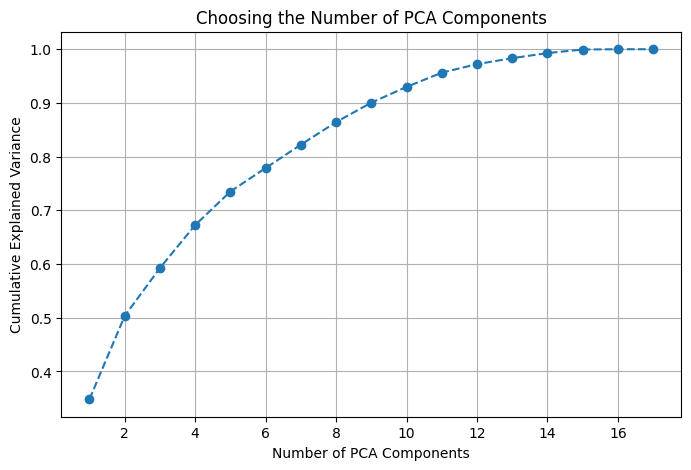

In [8]:
pca_full = PCA().fit(feature_matrix)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Choosing the Number of PCA Components")
plt.grid()
plt.show()


In [9]:
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(feature_matrix_pca)

kmeans_cluster_nums = np.unique(kmeans_clusters)
print("K-Means Unique Clusters:", kmeans_cluster_nums)

for i in kmeans_cluster_nums:
    print(f"K-Means Cluster {i} Size:", np.sum(kmeans_clusters == i))


K-Means Unique Clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
K-Means Cluster 0 Size: 7978
K-Means Cluster 1 Size: 6925
K-Means Cluster 2 Size: 206
K-Means Cluster 3 Size: 1665
K-Means Cluster 4 Size: 5915
K-Means Cluster 5 Size: 2434
K-Means Cluster 6 Size: 7399
K-Means Cluster 7 Size: 2658
K-Means Cluster 8 Size: 2
K-Means Cluster 9 Size: 2151
K-Means Cluster 10 Size: 255
K-Means Cluster 11 Size: 6918
K-Means Cluster 12 Size: 249
K-Means Cluster 13 Size: 3545
K-Means Cluster 14 Size: 1532
K-Means Cluster 15 Size: 1729
K-Means Cluster 16 Size: 3295
K-Means Cluster 17 Size: 1287
K-Means Cluster 18 Size: 957
K-Means Cluster 19 Size: 7072


In [10]:
dbscan = DBSCAN(eps=1, min_samples=20)
dbscan_clusters = dbscan.fit_predict(feature_matrix_pca)

print("DBSCAN Unique Clusters:", np.unique(dbscan_clusters))
dbscan_cluster_nums = np.unique(dbscan_clusters)

for i in dbscan_cluster_nums:
    print(f"DBSCAN Cluster {i} Size:", np.sum(dbscan_clusters == i))


DBSCAN Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
DBSCAN Cluster -1 Size: 3991
DBSCAN Cluster 0 Size: 30258
DBSCAN Cluster 1 Size: 840
DBSCAN Cluster 2 Size: 29
DBSCAN Cluster 3 Size: 30
DBSCAN Cluster 4 Size: 53
DBSCAN Cluster 5 Size: 26854
DBSCAN Cluster 6 Size: 1650
DBSCAN Cluster 7 Size: 81
DBSCAN Cluster 8 Size: 81
DBSCAN Cluster 9 Size: 38
DBSCAN Cluster 10 Size: 32
DBSCAN Cluster 11 Size: 64
DBSCAN Cluster 12 Size: 32
DBSCAN Cluster 13 Size: 34
DBSCAN Cluster 14 Size: 56
DBSCAN Cluster 15 Size: 22
DBSCAN Cluster 16 Size: 27


In [11]:
true_labels = df['app'].factorize()[0]
app_counts = df['app'].value_counts()
print(app_counts)

app
de.motain.iliga                7505
com.waze                       7214
com.duolingo                   4583
it.subito                      4299
com.contextlogic.wish          3927
com.accuweather.android        3737
com.joelapenna.foursquared     3627
com.spotify.music              3300
com.dropbox.android            3189
com.facebook.katana            2878
com.iconology.comics           2812
com.twitter.android            2805
com.google.android.youtube     2728
com.pinterest                  2450
com.tripadvisor.tripadvisor    2052
com.facebook.orca              1783
com.viber.voip                 1618
com.trello                     1478
com.groupon                    1174
air.com.hypah.io.slither       1013
Name: count, dtype: int64


In [12]:
tsne = TSNE(n_components=2, random_state=42)
feature_matrix_2D = tsne.fit_transform(feature_matrix_pca)

Silhouette Score: 0.2802
Adjusted Rand Index (ARI): 0.0489
Normalized Mutual Info (NMI): 0.1183


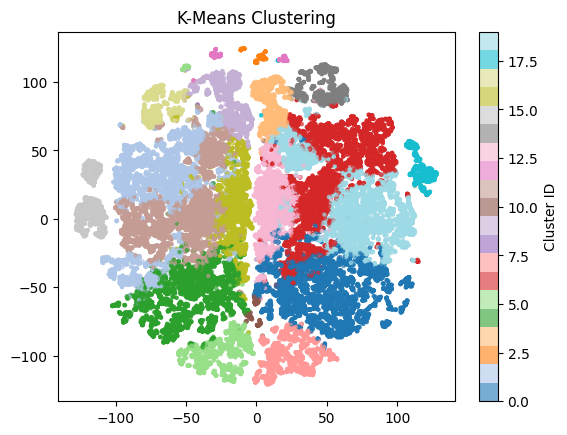

In [13]:
sil_score = silhouette_score(feature_matrix_pca, kmeans_clusters)
print(f"Silhouette Score: {sil_score:.4f}")

ari_score = adjusted_rand_score(true_labels, kmeans_clusters)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

nmi_score = normalized_mutual_info_score(true_labels, kmeans_clusters)
print(f"Normalized Mutual Info (NMI): {nmi_score:.4f}")

plt.scatter(feature_matrix_2D[:,0], feature_matrix_2D[:,1], c=kmeans_clusters, cmap='tab20', s=5, alpha=0.6)
plt.title("K-Means Clustering")
plt.colorbar(label="Cluster ID")
plt.show()

Silhouette Score: 0.1413
Adjusted Rand Index (ARI): 0.0122
Normalized Mutual Info (NMI): 0.0637


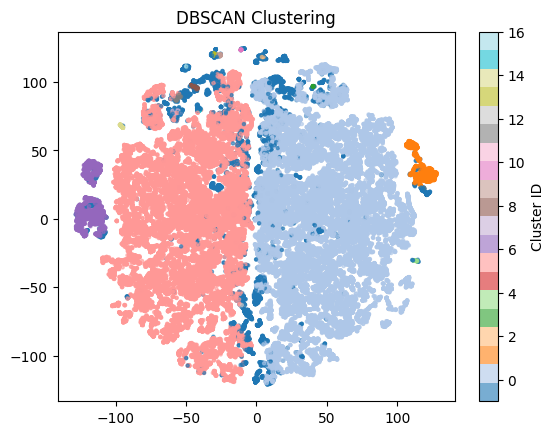

In [15]:
valid_points = dbscan_clusters != -1
if sum(valid_points) > 1:
    sil_score = silhouette_score(feature_matrix_pca[valid_points], dbscan_clusters[valid_points])
    print(f"Silhouette Score: {sil_score:.4f}")
else:
    print("Silhouette Score: No valid clusters found")

ari_score = adjusted_rand_score(true_labels, dbscan_clusters)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

nmi_score = normalized_mutual_info_score(true_labels, dbscan_clusters)
print(f"Normalized Mutual Info (NMI): {nmi_score:.4f}")

plt.scatter(feature_matrix_2D[:,0], feature_matrix_2D[:,1], c=dbscan_clusters, cmap='tab20', s=5, alpha=0.6)
plt.title("DBSCAN Clustering")
plt.colorbar(label="Cluster ID")
plt.show()

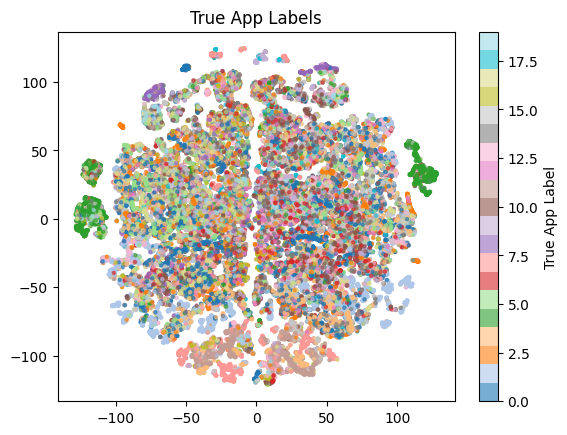

In [16]:
plt.scatter(feature_matrix_2D[:,0], feature_matrix_2D[:,1], c=true_labels, cmap='tab20', s=5, alpha=0.6)
plt.title("True App Labels")
plt.colorbar(label="True App Label")
plt.show()